## Otimizador (novo) — Fast / Hard
- **Fast**: avalia população inteira com surrogate (XGBoost) e valida os Top‑K no RocketPy a cada geração.
- **Hard**: usa 100% RocketPy para fitness.

In [5]:
import os

# Evita oversubscription: vários processos × várias threads BLAS/OpenMP = pode ficar MAIS lento
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

from airrocket.env import EnvConfig, make_env
from airrocket.optimizer import optimize_fast, optimize_hard, GAConfig, Objective
from airrocket.simulate import SimConfig, MonteCarloConfig
from airrocket.surrogate import load_bundle

# =========================
# Parâmetros importantes
# =========================
MODE = "fast"  # "fast" | "hard"
SURROGATE_PATH = "models/airrocket_surrogate.pkl"  # gerado no model.ipynb

TARGET_APOGEE_M = 3000.0
MIN_STABILITY_CAL = 2.0

# Fixos (exemplos): comente/descomente conforme quiser fixar
FIXED = {
    "num_grains": 3,
    "grain_h": 0.15,
    "tube_l": 1.8,
    "nose_l": 0.5,
    "throat_r": 0.008,
    "expansion_ratio": 6.0,
    # IMPORTANTE: `nozzle_exit_r` NÃO é uma variável de entrada do design.
    # Ele é DERIVADO no simulador por: nozzle_exit_r = throat_r * sqrt(expansion_ratio).
    # Portanto, colocar "nozzle_exit_r" aqui não fixa nada (o valor será recalculado).
    # Se quiser controlar o nozzle, fixe `throat_r` e/ou `expansion_ratio` (ou ajuste os bounds).
    # "fin_n": 4,
    # "nose_type": "vonKarman",
}

# Dica de viabilidade: com os bounds atuais, nozzle_exit_r fica limitado a ~0.007–0.038 m.
try:
    import math
    thr = float(FIXED.get("throat_r", float("nan")))
    eps = float(FIXED.get("expansion_ratio", float("nan")))
    if math.isfinite(thr) and math.isfinite(eps):
        print(f"nozzle_exit_r derivado (se throat_r+expansion_ratio fixos): {thr*math.sqrt(eps):.6f} m")
except Exception:
    pass

# Paralelismo (acelera validação Top-K no modo fast)
N_JOBS_VALIDATE = os.cpu_count() or 1

GA = GAConfig(
    pop_size=200,
    generations=20,
    elite_size=20,
    mutation_sigma=0.02,
    mutation_rate=0.25,
    crossover_rate=0.7,
    topk_validate=15,
    n_jobs_validate=N_JOBS_VALIDATE,
    random_state=42,
 )

SIM = SimConfig(
    rail_length_m=5.0,
    ode_solver="LSODA",
    terminate_on_apogee=False,
    max_time_s=300.0,
 )

# Monte Carlo: use SOMENTE no GA (validação Top-K no Fast, ou fitness inteiro no Hard)
USE_MC_IN_GA = True
MC_GA = MonteCarloConfig(
    n_runs=2,
    random_state=123,
    wind_profile="linear",
    wind_ref_alt_m=2500.0,
    wind_u_sigma_m_s=2.0,
    wind_v_sigma_m_s=2.0,
    wind_u_ref_sigma_m_s=6.0,
    wind_v_ref_sigma_m_s=6.0,
    wind_gust_sigma_m_s=0.0,
 )

env_cfg = EnvConfig()
env = make_env(env_cfg)
objective = Objective(target_apogee=TARGET_APOGEE_M, min_stability=MIN_STABILITY_CAL)

mc_cfg = MC_GA if USE_MC_IN_GA else None

if MODE.lower() == "fast":
    if not os.path.exists(SURROGATE_PATH):
        raise FileNotFoundError(
            f"Surrogate não encontrado: {SURROGATE_PATH}. Rode o bloco novo no model.ipynb para gerar esse arquivo."
        )
    bundle = load_bundle(SURROGATE_PATH)
    best_design, best_metrics = optimize_fast(
        env=env,
        env_cfg=env_cfg,
        objective=objective,
        ga=GA,
        surrogate_bundle=bundle,
        fixed=FIXED,
        sim_cfg=SIM,
        mc_cfg=mc_cfg,
    )
else:
    best_design, best_metrics = optimize_hard(
        env=env,
        env_cfg=env_cfg,
        objective=objective,
        ga=GA,
        fixed=FIXED,
        sim_cfg=SIM,
        mc_cfg=mc_cfg,
    )

print("\n=== Melhor design ===")
for k, v in best_design.items():
    print(f"{k}: {v}")

print("\n=== Métricas (GA) ===")
for k in ["ok","ok_rate","apogee","stability_min_over_flight","stability_at_max_q","max_mach","max_acceleration"]:
    if k in best_metrics:
        print(f"{k}: {best_metrics[k]}")

nozzle_exit_r derivado (se throat_r+expansion_ratio fixos): 0.019596 m
[GA fast] gen 1/20 best_fit=26.41 apogee=2973.6m stab_min=6.83cal, ok_rate=1.00 pop_ok=70.0%
[GA fast] top3 validated (gen 1)
  #1 fit=26.41 apogee=2973.6m stab_min=6.83cal ok_rate=1.00 | num_grains=3, grain_h=0.15, throat_r=0.008, expansion_ratio=6, tube_l=1.8, nose_type=ogive, fin_n=4, fin_root=0.1138, fin_span=0.07219
  #2 fit=296.1 apogee=2828.1m stab_min=9.30cal ok_rate=1.00 | num_grains=3, grain_h=0.15, throat_r=0.008, expansion_ratio=6, tube_l=1.8, nose_type=ogive, fin_n=4, fin_root=0.1175, fin_span=0.1592
  #3 fit=314.9 apogee=3262.9m stab_min=9.17cal ok_rate=1.00 | num_grains=3, grain_h=0.15, throat_r=0.008, expansion_ratio=6, tube_l=1.8, nose_type=conical, fin_n=4, fin_root=0.1492, fin_span=0.09021
[GA fast] gen 10/20 best_fit=26.41 apogee=2973.6m stab_min=6.83cal, ok_rate=1.00 pop_ok=95.0%
[GA fast] top3 validated (gen 10)
  #1 fit=1814 apogee=1293.2m stab_min=12.35cal ok_rate=1.00 | num_grains=3, grain_h

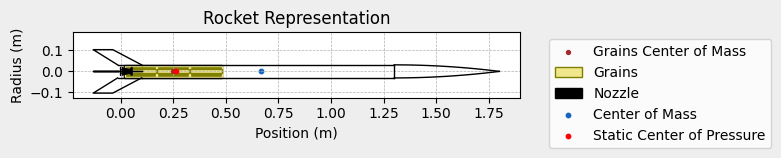


=== Nozzle sanity ===
throat_r: 0.008
expansion_ratio: 6.0
nozzle_exit_r (calc): 0.019595917942265423
motor.nozzle_radius: 0.019595917942265423
motor.throat_radius: 0.008
derived.tube_r: 0.03105934645414936
CHECK nozzle <= tube ?: True

=== Motor positioning (RocketPy attrs) ===
nozzle_position = 0.0
center_of_dry_mass_position = 0.24999999999999997
center_of_mass_position = None


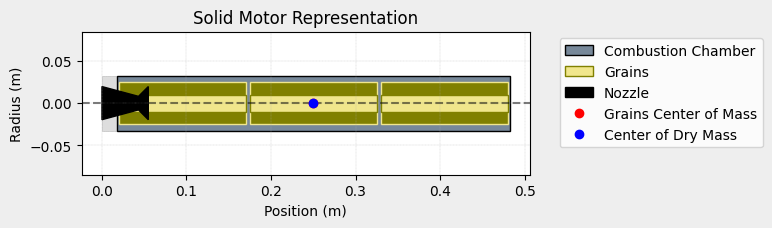


=== Validação final (RocketPy) ===
apogee: 3389.83 m
rail_exit_speed: 24.60 m/s
stability_initial: 6.54 cal
stability_min_over_flight: 6.54 cal
stability_at_max_q: 8.17 cal

=== Monte Carlo (resumo) ===
ok_rate: 100.0% (30/30)
wind_u0 mean±std: -0.18 ± 1.80 m/s
wind_v0 mean±std: 0.18 ± 2.07 m/s
wind_u@2500m mean±std: 1.46 ± 5.46 m/s
wind_v@2500m mean±std: 1.37 ± 5.54 m/s
apogee p5/p50/p95: 2843.8 / 3405.3 / 3938.7 m
stability_min p5/p50/p95: 5.80 / 6.30 / 7.27 cal
stability@maxQ p5/p50/p95: 7.49 / 8.00 / 8.78 cal


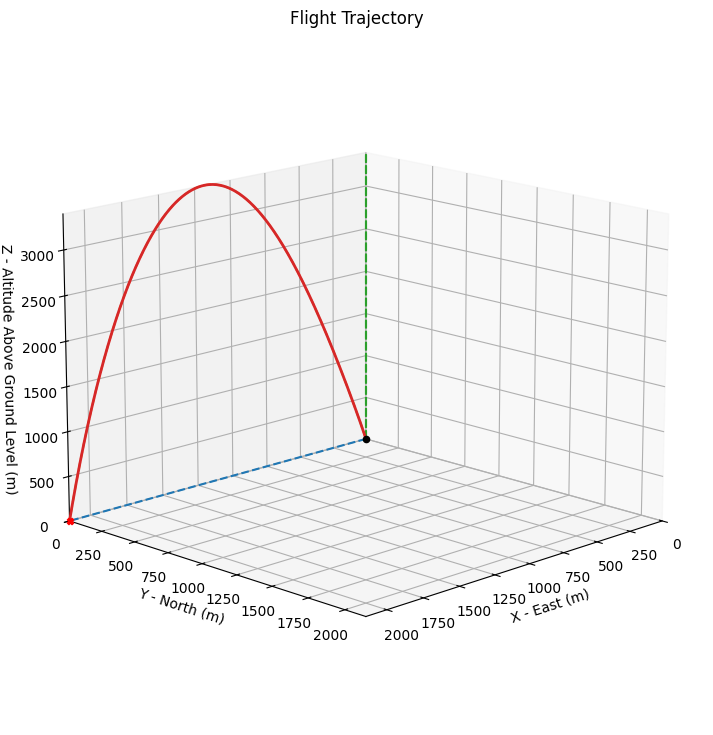

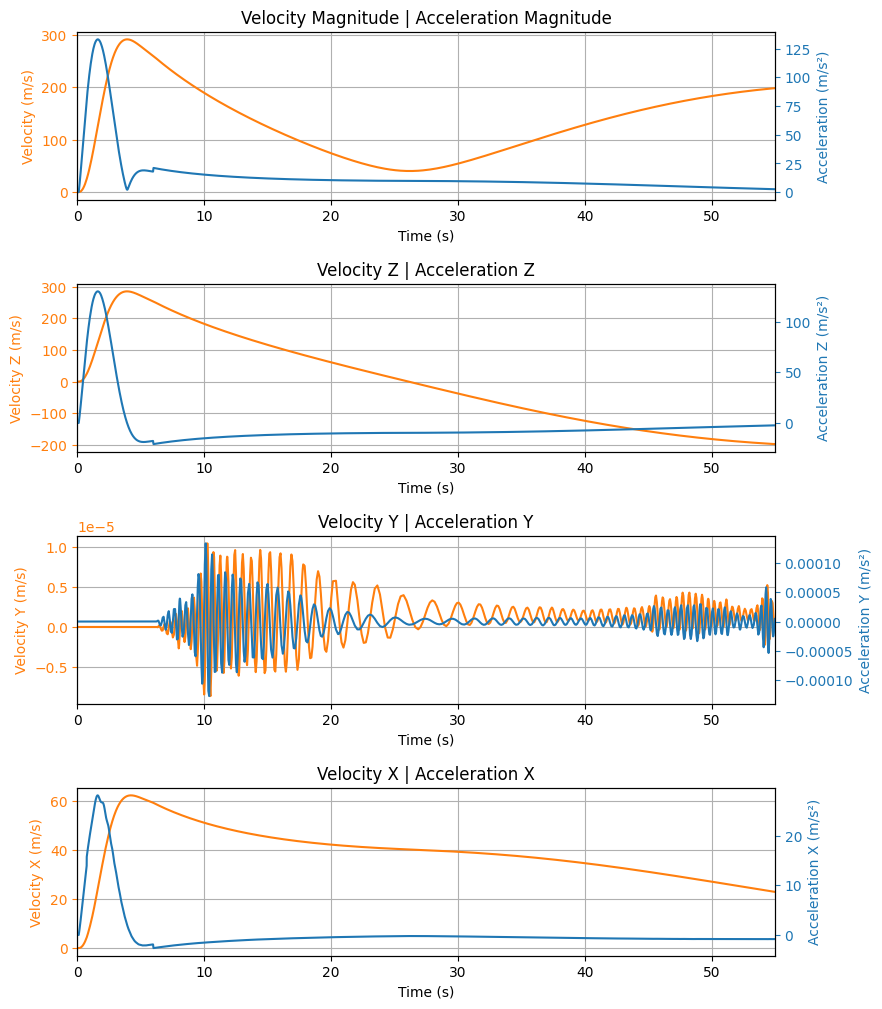

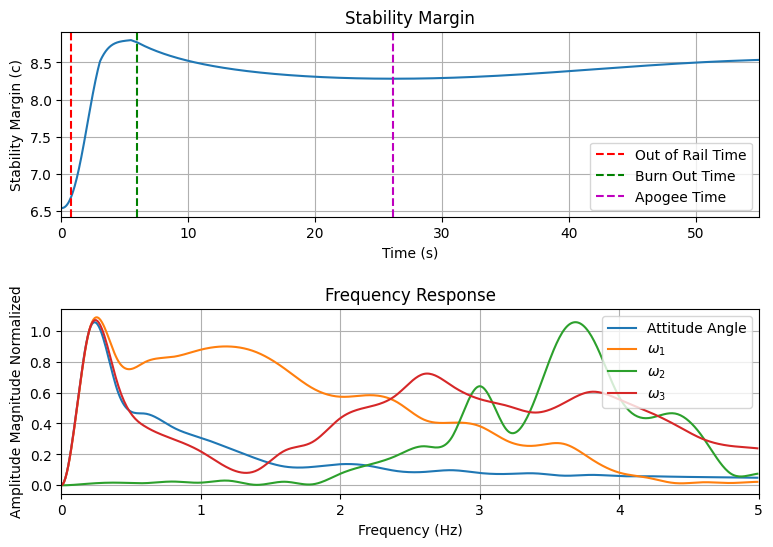

In [9]:
from rocketpy import Flight
from airrocket.simulate import build_motor, build_rocket, simulate_monte_carlo, MonteCarloConfig
from airrocket.constraints import check_constraints
import numpy as np
import math

# =========================
# Validação final + plots
# =========================
# Re-simula o melhor design no RocketPy para gerar o objeto Flight e gráficos.
motor, motor_derived = build_motor(best_design, SIM)
final_rocket, derived = build_rocket(best_design, motor, motor_derived, SIM)

# Desenho do foguete (RocketPy)
try:
    draw_fn = getattr(final_rocket, "draw", None)
    if callable(draw_fn):
        draw_fn()
    else:
        print("Rocket.draw() não disponível nesta versão do RocketPy.")
except Exception as e:
    print(f"(draw falhou) {e}")

thr = float(best_design.get("throat_r", float("nan")))
eps = float(best_design.get("expansion_ratio", float("nan")))
nozzle_exit_r_calc = thr * math.sqrt(eps) if math.isfinite(thr) and math.isfinite(eps) else float("nan")

print("\n=== Nozzle sanity ===")
print("throat_r:", thr)
print("expansion_ratio:", eps)
print("nozzle_exit_r (calc):", nozzle_exit_r_calc)
print("motor.nozzle_radius:", getattr(motor, "nozzle_radius", None))
print("motor.throat_radius:", getattr(motor, "throat_radius", None))
print("derived.tube_r:", derived.get("tube_r"))
print("CHECK nozzle <= tube ?:", getattr(motor, "nozzle_radius", float("nan")) <= float(derived.get("tube_r", float("nan"))))

print("\n=== Motor positioning (RocketPy attrs) ===")
for a in ["nozzle_position", "center_of_dry_mass_position", "center_of_mass_position"]:
    print(a, "=", getattr(motor, a, None))

# Teste: desenhar só o motor (se existir)
draw_motor = getattr(motor, "draw", None)
if callable(draw_motor):
    draw_motor()
else:
    print("motor.draw() não disponível")

c = check_constraints(best_design, derived)
if not c.ok:
    print("AVISO: Melhor design viola constraints:")
    print(" - " + "\n - ".join(c.reasons))

final_flight = Flight(
    rocket=final_rocket,
    environment=env,
    rail_length=float(SIM.rail_length_m),
    ode_solver=str(SIM.ode_solver),
    terminate_on_apogee=bool(SIM.terminate_on_apogee),
    max_time=float(SIM.max_time_s),
)

apogee = float(getattr(final_flight, "apogee", float("nan")))
rail_exit_v = float(getattr(final_flight, "out_of_rail_velocity", float("nan")))
max_q_t = float(getattr(final_flight, "max_dynamic_pressure_time", float("nan")))
stability_at_max_q = float(final_rocket.static_margin(max_q_t)) if math.isfinite(max_q_t) else float("nan")

print("\n=== Validação final (RocketPy) ===")
print(f"apogee: {apogee:.2f} m" if np.isfinite(apogee) else f"apogee: {apogee}")
print(f"rail_exit_speed: {rail_exit_v:.2f} m/s" if np.isfinite(rail_exit_v) else f"rail_exit_speed: {rail_exit_v}")
print(f"stability_initial: {final_rocket.static_margin(0):.2f} cal")
print(f"stability_min_over_flight: {float(getattr(final_flight, 'min_stability_margin', float('nan'))):.2f} cal")
print(f"stability_at_max_q: {stability_at_max_q:.2f} cal")

# =========================
# Monte Carlo (incertezas)
# =========================
# Inclui incertezas de motor + massa + tolerâncias + VENTO (perfil linear com altitude).
RUN_MONTE_CARLO = True
MC = MonteCarloConfig(
    n_runs=30,
    random_state=123,
    wind_profile="linear",
    wind_ref_alt_m=2500.0,
    wind_u_sigma_m_s=2.0,
    wind_v_sigma_m_s=2.0,
    wind_u_ref_sigma_m_s=6.0,
    wind_v_ref_sigma_m_s=6.0,
    wind_gust_sigma_m_s=0.0,
 )

if RUN_MONTE_CARLO:
    mc = simulate_monte_carlo(best_design, env, SIM, MC)
    plo = f"p{int(MC.p_lo)}"
    phi = f"p{int(MC.p_hi)}"
    print("\n=== Monte Carlo (resumo) ===")
    print(f"ok_rate: {mc['mc_ok_rate']*100:.1f}% ({mc['mc_ok']}/{mc['mc_n']})")
    if mc.get('mc_fail_reason_counts'):
        print(f"fail_reasons: {mc['mc_fail_reason_counts']}")
    print(f"wind_u0 mean±std: {mc['wind_u_stats']['mean']:.2f} ± {mc['wind_u_stats']['std']:.2f} m/s")
    print(f"wind_v0 mean±std: {mc['wind_v_stats']['mean']:.2f} ± {mc['wind_v_stats']['std']:.2f} m/s")
    print(f"wind_u@{MC.wind_ref_alt_m:.0f}m mean±std: {mc['wind_u_ref_stats']['mean']:.2f} ± {mc['wind_u_ref_stats']['std']:.2f} m/s")
    print(f"wind_v@{MC.wind_ref_alt_m:.0f}m mean±std: {mc['wind_v_ref_stats']['mean']:.2f} ± {mc['wind_v_ref_stats']['std']:.2f} m/s")
    print(f"apogee {plo}/p50/{phi}: {mc['apogee_stats'][plo]:.1f} / {mc['apogee_stats']['p50']:.1f} / {mc['apogee_stats'][phi]:.1f} m")
    print(f"stability_min {plo}/p50/{phi}: {mc['stability_min_over_flight_stats'][plo]:.2f} / {mc['stability_min_over_flight_stats']['p50']:.2f} / {mc['stability_min_over_flight_stats'][phi]:.2f} cal")
    print(f"stability@maxQ {plo}/p50/{phi}: {mc['stability_at_max_q_stats'][plo]:.2f} / {mc['stability_at_max_q_stats']['p50']:.2f} / {mc['stability_at_max_q_stats'][phi]:.2f} cal")

# =========================
# Plots (RocketPy 1.11+)
# =========================
plots_obj = getattr(final_flight, "plots", None)
if plots_obj is None:
    print("Sem suporte a plots nesta versão do RocketPy.")
else:
    preferred = ["trajectory_3d", "linear_kinematics_data", "stability_and_control_data"]
    for name in preferred:
        fn = getattr(plots_obj, name, None)
        if callable(fn):
            try:
                fn()
            except Exception as e:
                print(f"(plot falhou) {name}: {e}")

In [7]:
from pprint import pprint
import math


def _print_dict(title: str, d: dict | None):
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)
    if not isinstance(d, dict) or not d:
        print("(vazio ou não definido)")
        return
    for k in sorted(d.keys()):
        v = d.get(k)
        if isinstance(v, float):
            if math.isfinite(v):
                print(f"{k}: {v:.6g}")
            else:
                print(f"{k}: {v}")
        else:
            print(f"{k}: {v}")


def _safe_attr(obj, name: str):
    try:
        return getattr(obj, name)
    except Exception:
        return "<erro ao acessar>"


# 1) Variáveis principais do design (entradas)
_print_dict("DESIGN (best_design)", globals().get("best_design"))

# 2) Variáveis derivadas pelo modelo (motor/estrutura)
_print_dict("DERIVED (derived)", globals().get("derived"))
_print_dict("MOTOR DERIVED (motor_derived)", globals().get("motor_derived"))

# 3) Métricas finais (se você estiver usando best_metrics)
_print_dict("METRICS (best_metrics)", globals().get("best_metrics"))

# 4) Resumo de objetos RocketPy, se existirem
print("\n" + "=" * 80)
print("ROCKETPY OBJECT SUMMARY")
print("=" * 80)

final_rocket = globals().get("final_rocket")
motor = globals().get("motor")
final_flight = globals().get("final_flight")

def _print_obj_summary(name: str, obj, attrs: list[str]):
    print(f"\n{name}: {type(obj)}")
    if obj is None:
        print("(não definido)")
        return
    for a in attrs:
        print(f"- {a}: {_safe_attr(obj, a)}")


_print_obj_summary(
    "final_rocket",
    final_rocket,
    [
        "radius",
        "mass",
        "inertia",
        "center_of_mass_without_motor",
        "coordinate_system_orientation",
    ],
)

_print_obj_summary(
    "motor",
    motor,
    [
        "burn_time",
        "dry_mass",
        "nozzle_radius",
        "throat_radius",
        "grain_number",
        "grain_density",
        "grain_outer_radius",
        "grain_initial_inner_radius",
        "grain_initial_height",
        "grain_separation",
    ],
)

_print_obj_summary(
    "final_flight",
    final_flight,
    [
        "apogee",
        "max_mach_number",
        "max_acceleration",
        "max_dynamic_pressure",
        "out_of_rail_velocity",
        "max_dynamic_pressure_time",
    ],
)

# 5) Um “pacote” único (inputs + derivadas + métricas) em formato tabela, se possível
try:
    import pandas as pd

    bundle = {}
    for name in ("best_design", "derived", "motor_derived", "best_metrics"):
        d = globals().get(name)
        if isinstance(d, dict):
            bundle.update(d)

    if bundle:
        print("\n" + "=" * 80)
        print("BUNDLE (design + derived + metrics)")
        print("=" * 80)
        display(pd.DataFrame({"value": pd.Series(bundle)}))
except Exception as e:
    print(f"(não foi possível gerar tabela com pandas) {e}")



DESIGN (best_design)
burn_rate: 0.00211809
curve_alpha: 2.61576
curve_beta: 5.61309
eta_thrust: 0.881405
expansion_ratio: 6
fin_n: 4
fin_root: 0.113787
fin_span: 0.072192
fin_sweep: 0.137007
fin_tip: 0.0928434
grain_h: 0.15
grain_in_r: 0.00998521
grain_out_r: 0.0250593
isp_eff_s: 186.91
nose_l: 0.5
nose_type: ogive
num_grains: 3
prop_density: 1681.26
throat_r: 0.008
tube_l: 1.8

DERIVED (derived)
burn_time_s: 6
max_thrust_n: 818.972
motor_casing_length: 0.5
motor_dry_mass_kg: 0.939458
nozzle_exit_r: 0.0195959
prop_mass_kg: 1.2556
rocket_mass_est_kg: 3.95
thrust_tau05_n: 194.44
total_impulse_ns: 2028.52
tube_d: 0.0621187
tube_r: 0.0310593

MOTOR DERIVED (motor_derived)
burn_time_s: 6
max_thrust_n: 818.972
motor_dry_mass_kg: 0.939458
nozzle_exit_r: 0.0195959
prop_mass_kg: 1.2556
thrust_tau05_n: 194.44
total_impulse_ns: 2028.52

METRICS (best_metrics)
apogee: 2973.59
max_acceleration: 119.005
max_mach: 0.774097
ok: True
ok_rate: 1
stability_at_max_q: 8.32001
stability_min_over_flight: 6.

,value
num_grains,3
grain_h,0.15
grain_out_r,0.025059
grain_in_r,0.009985
throat_r,0.008
expansion_ratio,6.0
tube_l,1.8
nose_l,0.5
nose_type,ogive
fin_n,4
